Every day any business seeks ways for best optimization of its processes. 


Someone needs to minimize empty space in sea containers to maximize amount of goods that could be shipped because this will minimize costs and thus maximize profits. 

Candy makers have to optimize their plan of production every month for hundreds of SKUs according to current demand (with correction on upcoming seasonality) with the purpose of maximizing revenues. But also, it is desirable to minimize costs: operating this may require to optimize the production of certain SKUs, and this may not match the goals of revenue maximization.



Imagine we are the bosses of a small pizzeria. But despite it is small, it is very popular because we cook pizza by “family” receipt and thus we have many delivery orders during the day. Now we have several pizza delivery boys, but as the business is growing and the area of customers expands, we faced the optimization problem of delivery process: 

“What is better: 
- to hire ‘n’ more cyclist
- or buy ‘m’ cars (electric ones, as we are nature friendly business :) ) and to fire all cyclist (what may be not human friendly (: ).” 

Here is the task in numbers:

![alt text](https://gist.githubusercontent.com/umachkaalex/c4e887ed7979c8e503b5b9eb87712d2f/raw/49391afa7d9c8c1f8240b7e0626219b521d7df0d/image_01.png)

Total number of deliveries per day that we have to manage = 200.

Here we can write the function:

![alt text](https://gist.githubusercontent.com/umachkaalex/c4e887ed7979c8e503b5b9eb87712d2f/raw/24e17194400f3f97ea3c8403c5d304bd9e9de2c7/image_02.png)

So, we want to know what is the optimal combination of numbers of cyclist and cars which would give us the lowest costs and could manage to deliver 200 pizzas per day.
Such simple task could be solved by trivial brute force, but assuming that the number of delivery option could be much bigger and solving by combination of parameters would become much longer, here we can use Excel Solver:

![alt text](https://gist.githubusercontent.com/umachkaalex/c4e887ed7979c8e503b5b9eb87712d2f/raw/12ae72510871a5b4eccd25c05462143e3c969075/image_03.png)

The optimal combination here would be: 17 cyclist and 0 cars. Simple task - fast solvation.
[link text](https://)But in the age of big data Excel Solver cannot compute huge datasets, that's why, further we are going to talk about SLSQP optimization from Python Scipy library and custom-built random optimization written within Python, which could be in plenty of cases more convenient tools to solve such optimization problems.


After reading the article we will find out:
- how to build and run SLSQP optimization using scipy.optimize.minimize tool;
- how to add constraints to such optimization;
- what advantages and disadvantages of SLSQP-like methods are;
- how to build and run random optimization;
- in which cases random optimization could be more helpful compared to SLSQP.

Let's take an example from real world - from the world of stock market. 
Say, you want your investment portfolio to be optimized (or set up) based on last month stock movements (believing the last month results would be the similar the next month). 
Let's load the stock data and python libraries that we will use and look inside the data.

In [0]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import matplotlib.style
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from scipy.optimize import minimize
# from tqdm import tqdm

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 10)
np.set_printoptions(suppress=True)
matplotlib.style.use('classic')

In [0]:
url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/pr_data_closes.csv'       
# load previous month data
all_pr_data_closes = pd.read_csv(url)
# delete columns (stocks) with zero closes
all_pr_data_closes = all_pr_data_closes.replace(0, pd.np.nan).dropna(axis=1)
# create list of symbols 'Date' column
all_pr_tickers = all_pr_data_closes.columns.tolist()[:-1]

# convert dataframes to numpy arrays without 'Date' column
all_pr_data_closes = all_pr_data_closes.values[:,:-1]


# set start/end dates for previous and next periods  
pr_start_date = pd.to_datetime('11/30/2017')
pr_end_date = pd.to_datetime('12/31/2017')

Here we have the clothes prices of almost 5500 stocks for December 2017 and ass the result of optimization, we want to get the list of stocks and the list of their weights in portfolio which would maximize certain parameter (for example: returns) or vice versa - minimize (for example: risks). In our case we will use the financial industry common standard - Sharpe ratio as the portfolio performance indicator:

![alt text](https://gist.githubusercontent.com/umachkaalex/c4e887ed7979c8e503b5b9eb87712d2f/raw/5f25036c56159357a53ec7b1c61f025f212824dc/image_04.png)


By simple, Sharpe ratio uses portfolio return as numerator and portfolio risk as denominator and it shows how profitable our investments regarding risk. (To know more about this ratio you can read [this investopedia article](https://www.investopedia.com/terms/s/sharperatio.asp)).
Graphically, this can be represented like this:

![alt text](https://gist.githubusercontent.com/umachkaalex/c4e887ed7979c8e503b5b9eb87712d2f/raw/f4f9bbf00795e788e994013fac3b4e3c2fd67cd3/image_05.png)

These lines represent two different returns on investments that you can make (into two different businesses):  which one is more preferable?
Both of them have comparable income but quit different risks (amplitude or standard deviation of income). So, to measure what is better we can divide return by risk and get ratio that we want to maximize. This will give us such portfolio allocation that produces the maximally possible return with minimally possible risk.

Here is the process of calculation the Sharpe ratio to two stocks:

![alt text](https://gist.githubusercontent.com/umachkaalex/c4e887ed7979c8e503b5b9eb87712d2f/raw/f4f9bbf00795e788e994013fac3b4e3c2fd67cd3/image_06.png)

With stocks allocation (weights) [0.7, 0.3] we've got Sharpe ratio value that equals 1.68. But we want to get best solution! We can manually assign several different weights combinations and get such chart:

![alt text](https://gist.githubusercontent.com/umachkaalex/c4e887ed7979c8e503b5b9eb87712d2f/raw/f4f9bbf00795e788e994013fac3b4e3c2fd67cd3/image_07.png)

As we see the best allocation regarding Sharpe ratio is 40% of stock #1 and 60% of stock #2, because it gives us almost the same return as the 0.1/0.9 variant, but with much lower deviation (risk).

But we have over 5 thousands of stocks and manual change of weights is not promising work. Excel Solver requires big amount of hardware resources to calculate huge matrices so let's write all required functions to calculate and optimize (maximize) the Sharpe ratio using.

We will start from function which will return Sharpe ratio, CAGR (return), standard deviation (risk).

In [0]:
def calc_fin_indicators(port_capital, start, end):
    # define empty dictionary as container for next calculations.
    fin_indicators = {}
    
    # calculcate the amount of years. it is needed to calculate CAGR
    pr_years = (end-start).days/365
    
    # calculcate portfolio return: portfolio value at the end of the period
    # devide on portfolio value at the start of the period.
    gain = port_capital[-1] / port_capital[0]
    
    # calculate CAGR
    CAGR = gain ** (1 / pr_years) - 1
    
    # calculate daily returns: portfolio value at the end of the current day
    # devide on portfolio value at the end of the previous day.
    daily_gain = np.diff(port_capital, axis=0) / port_capital[:-1]
    
    # calculate standard deviation as it is considered as portfolio risk.
    std = np.std(daily_gain, ddof=1)*np.sqrt(252)
    
    # calculate sharpe ration
    sharpe = CAGR / std
    
    # add financial parameters to dictionary
    fin_indicators['sharpe'] = sharpe
    fin_indicators['CAGR'] = CAGR
    fin_indicators['st_dev'] = std

    return fin_indicators


To calculate financial metrics this function requires daily portfolio performance for the period defined by start and end dates. So let's write such function.

In [0]:
def port_capital_flow(closes_data, st_cap, weights):
    # define the shape of array with closes
    m_shape = closes_data.shape
    
    # initialize the empty array to store the amount of shares
    num_shares_data = np.zeros(m_shape)
    
    # initialize the empty array to store the portfolio perfomance
    capital_data = np.zeros(m_shape)
    
    # start loop to calculate every day values of portfolio`s positions.
    for m in range(capital_data.shape[0]):
        if m == 0:
            # if this is the first day of period: the initial value of portfolio
            # equals the starting capital
            cur_cap = st_cap
            # distribute the starting capital between stocks using the list of
            # weights            
            capital_data[m, :] = weights*cur_cap            
            # calculate the number of shares (that we will hold during current 
            # period) based on distributed capital            
            num_shares_data[0, :] = capital_data[m, :]/closes_data[m, :]            
        else:
            # if this is not the first day of period: calculate portfolio
            # performance using the number of shares and daily stock closes 
            capital_data[m, :] = num_shares_data[0, :]*closes_data[m, :]
    
    # summarize performance of all opened positions (columns)     
    port_perform = np.sum(capital_data, axis=1)
    
    return port_perform


In turn to calculate daily portfolio performance we need the list of weights:
- the array of clothes we've already defined
- “st_cap” is an integer, which determines the capital at the start of period.

Also, the list of weights is the object of optimization - this is the only value we can change to aim our goal - maximally possible Sharpe ratio.

As our function is nonlinear and we have certain constraint (the sum of weights has to equal 1)  we will use nonlinearly constrained gradient-based optimization: Sequential Least SQuares Programming (SLSQP) algorithm. For this purpose we have loaded sklearn.optimize.minimize library. 

So, let us write the function which will optimize weights that will maximize portfolio return and minimize risk (standard deviation) and thus maximize Sharpe ratio. Remember that for now we are working in “past” period: we look back, optimize weights to see how it would be if it is as algorithm calculated.

In [0]:
def algo_optimization(closes_data, weights, st_cap, start, end, max_pos):
    # objective function    
    def f(opt_w):
        # calculate portfolio performance for the period using current weights        
        capital_flow = port_capital_flow(closes_data, st_cap, opt_w)        
        # calculate target financial metric of this performance
        fin_indicators = calc_fin_indicators(capital_flow, start, end)
        # return target metric with negative sign to maximize it 
        # (opposite minimization)
        return - fin_indicators['sharpe']

    # constrains
    def constraint(x):
        # the sum of all weights of opened (more the 0) positions should equal 1
        # also add '-1' to execute maximization 
        return -1 * (1 - sum(x))
    
    # add constrains to dictionary 
    con = ({'type': 'eq', 'fun': constraint})
    
    # add bounds to our weights: as in real life the sum weights of all open position
    # should not be more than 1 (more than available amount of money) and less 
    # than 0 (for now let`s not take in account possible short positions) 
    cur_bounds = [(0.0, max_pos) for l in range(len(weights[0]))]
    
    # execute SLSQP optimization process
    opt_w = weights   
    f(opt_w)
    res = minimize(f, opt_w, method='SLSQP', bounds=cur_bounds, constraints=con,
                   options={'maxiter': 1000, 'ftol': 1e-10})
    
    # after completing optimization minimize function returns dictionary with
    # various information. We need:
    # the value of objection function (sharpe ratio). It`s negative because of 
    # above multiplying in purpose of maximization, so here we multiply by -1 one 
    # more time 
    opt_param_value = -1*res['fun']
    # number or iterations was needed to complete optimization 
    opt_iter = res['nit']
    # the array of optimized weights which give maximal sharpe 
    opt_weights = np.round(res['x'], 4)
    
    # put this variables into dictionary:
    opt_dict = ({'opt_param_value': opt_param_value,
                 'opt_iter': opt_iter,
                 'opt_weights': opt_weights})

    return opt_dict


Additionally, we need one more function that will correct the optimized weights a little bit. As we optimize nonlinear function and there is constraint term, the sum of output weights does not always equal 1. So, we have to add several additional lines of code to correct this.

In [0]:
def correct_weights(opt_weights, corr_value=0.001):
  # set to zeros weights that less than certain value (very little weights - as 
  # in real stock market we would never buy 1 stock, if 1000 is normal size)
    idx_less = (opt_weights < corr_value)
    idx_over = (opt_weights >= corr_value)
    subs = np.sum(opt_weights[idx_less])    
    subs_s = subs/np.sum(idx_over*1)
  # distribute across non-zero stocks weights of those that set to zeros.
    opt_weights[idx_over] += subs_s    
    opt_weights[idx_less] = 0
    subs_s = 1-np.sum(opt_weights)
    opt_weights[idx_over] += subs_s/np.sum(idx_over*1)
    
    return opt_weights


Before we combine all functions in one process, we have to answer how we will initialize weights at start: should it be equal weights or random weights?

As we deal with gradient-based optimization we can turn to the machine learning theories and particularly to backpropagation and initialize weights randomly as it is more efficient for gradient calculations. But to be sure we are going in right way we will create two functions to get both equal and random weights. Later we will compare these two approaches.

In [0]:
def init_weights(data, random=True):
    # def shape of array of closes to create the same shape array of weights
    shape = data.shape[1]        
    if random:
        # create random weights
        weights = np.random.rand(shape).reshape(1, shape)
        weights = weights/np.sum(weights)
    else:
        # create equal weights
        weights = np.asarray([1/shape]*shape).reshape(1, shape)
        
    return weights


Now we can gather all functions into one and run optimization procedure, for example, with 10 first stocks of our dataset.

In [0]:
def optimization_procedure(algo_function, data, start, end, st_cap, n_iter=1, 
                           random=True, corr_value=0.001, max_pos=1., show_w=False,
                           show_f=False):
    init_target_param = []
    opt_param = []
    optimization_port = []
    optimization_iter = []    
    num_opt_weights = []
    
    # start loop to run 'n_iter' optimizations with various random weights
    for i in range(n_iter):
        # with each loop change randomness
        np.random.seed(i)
        # initial weights
        weights = init_weights(data, random)
        # calculate portfolio performance with initial weights        
        p_eq_perf = port_capital_flow(data, st_cap, weights)
        # calculate and store target parameter based on initial weights 
        # portfolio performance
        init_fin_param_dic = calc_fin_indicators(p_eq_perf, start, end)
        init_target_param.append(init_fin_param_dic['sharpe'])
        # if it is needed, print last optimized weights        
        if show_w:            
            print('Initialized weights: ' + str(weights))
            print('Sum of weights: ' + str(np.sum(weights)))
            print('Performance with init-weights: ' + str(int(p_eq_perf[-1])))            
        # run optimization and store its results
        opt_results = algo_function(data, weights, st_cap,
                                        start, end, max_pos)
        
        # save the number of iteration of current loop 
        optimization_iter.append(opt_results['opt_iter'])
        
        # correct weights
        opt_weights = correct_weights(opt_results['opt_weights'], corr_value)
        opt_weights = correct_weights(opt_weights, corr_value)
        # save the number of weights that not equal 0. In other words here we 
        # store the number of opened position in our portfolio
        num_opt_weights.append(np.sum((opt_weights > 0)*1))
        # store the value of maximized target parameter
        opt_param.append(opt_results['opt_param_value'])
        # calculate and store the portfolio return for given period.
        random_rand_opt_port = (int(port_capital_flow(data, st_cap, opt_weights)[-1]))
        optimization_port.append(random_rand_opt_port)
    
    # if it is needed print fin. indicators
    if show_f:
        last_opt_wght_perf = port_capital_flow(data, st_cap, opt_weights)
        print(calc_fin_indicators(last_opt_wght_perf, start, end))
    # if it is needed, print last optimized weights
    if show_w:
        print('Optimized weights: ' + str(opt_weights))
        print('Sum of weights: ' + str(np.sum(opt_weights)))
    # create dataframe to store and export metrics of optimization  
    exp_dict = pd.DataFrame({'Init Weights Param':
                             [np.mean(init_target_param)],
                             'Mean Opt Param':
                             [np.mean(opt_param)],
                             'Mean Num Weights':
                             [np.mean(num_opt_weights)],
                             'Mean Port Return': 
                             [np.mean(optimization_port)],                             
                             'Mean Optim Iter':
                             [np.mean(optimization_iter)]
                             })
    # calculate mean of DataFrame if there are more than 1 row.    
    if len(exp_dict) > 1:
        exp_dict = pd.DataFrame(exp_dict.mean(axis=0).T)    
    
    return exp_dict


In [0]:
print('Random:')
rand_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, :10], 
                                      pr_start_date, pr_end_date, 10000,
                                      random=True, show_w=True)
print(rand_opt_dic)
print('Equal:')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, :10],
                                    pr_start_date, pr_end_date, 10000,
                                    random=False, show_w=True)
print(eq_opt_dic)

Random:
Initialized weights: [[0.08912692 0.11614624 0.09788834 0.08848864 0.06880123 0.10489274
  0.07106385 0.14482329 0.15649814 0.06227063]]
Sum of weights: 1.0
Performance with init-weights: 9858
Optimized weights: [0.     0.     0.     0.3453 0.     0.1506 0.0789 0.     0.4252 0.    ]
Sum of weights: 1.0
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0           -0.891876        4.895913               4.0           10357.0   

   Mean Optim Iter  
0             17.0  
Equal:
Initialized weights: [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
Sum of weights: 1.0
Performance with init-weights: 9827
Optimized weights: [0.     0.     0.     0.3453 0.     0.1506 0.0789 0.     0.4252 0.    ]
Sum of weights: 1.0
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0           -1.044437        4.895913               4.0           10357.0   

   Mean Optim Iter  
0             19.0  


As we see the optimization process has worked well. 
The portfolio Sharpe ratio after optimization became much better:
- with randomly initialized weights target parameter was -0.89 before running and after optimization it became +4.895. Such gain is obtained first of all because of the return that became positive after optimization - +3.57% (it was -1.73%: 9827/10000 - 1, where 9827 is portfolio value at the end of the period, 10000 - the start value).

- with equal weights the Sharpe ratio was -1.04 before optimization and became +4.895 after it.

The optimization “determined” that 4 opened positions are better than 10.
We received optimized weights both similar for random and equal initialized weights strategies. But with random weights finding local maximum is a little bit faster (15 iteration vs 18 iteration with equal weights).
Let's run script with bigger numbers of stocks: 20, 50 and 100.

In [0]:
print('********20 stocks********')
print('Random:')
rand_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:20], 
                                      pr_start_date, pr_end_date, 10000,
                                      random=True)
print(rand_opt_dic)
print('Equal:')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:20], 
                                    pr_start_date, pr_end_date, 10000,
                                    random=False)
print(eq_opt_dic)
print('********50 stocks********')
print('Random:')
rand_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:50],  
                                      pr_start_date, pr_end_date, 10000,
                                      random=True)
print(rand_opt_dic)
print('Equal:')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:50],
                                    pr_start_date, pr_end_date, 10000,
                                    random=False)
print(eq_opt_dic)
print('********100 stocks********')
print('Random:')
rand_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:100], 
                                      pr_start_date, pr_end_date, 10000,
                                      random=True)
print(rand_opt_dic)
print('Equal:')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:100], 
                                    pr_start_date, pr_end_date, 10000,
                                    random=False)
print(eq_opt_dic)


********20 stocks********
Random:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0           -1.463664        8.114818               9.0           10138.0   

   Mean Optim Iter  
0             47.0  
Equal:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0           -1.309603        8.114818               9.0           10138.0   

   Mean Optim Iter  
0             56.0  
********50 stocks********
Random:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            1.112623       28.207089               1.0           13749.0   

   Mean Optim Iter  
0              6.0  
Equal:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            0.160828       28.207089               1.0           13749.0   

   Mean Optim Iter  
0              3.0  
********100 stocks********
Random:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            1.793

Looking at the optimization results of 50- and 100-stocks slicing we can observe quite different results: the algorithm determined that the “best” choice is to keep 1 stock in portfolio. In terms of theory of portfolio management it is not a good idea  [(read here)](https://www.investopedia.com/ask/answers/05/optimalportfoliosize.asp) despite we have got much larger Sharpe ratios after optimization. And this was caused by the bounds that we wrote in the “algo_optimization” function:

*cur_bounds = [(0.0, max_pos) for l in range(len(weights[0]))]*

This line means that the algorithm is allowed to assign to every open position from 0 up to “max_pos” weight in the portfolio. And as the default value is 1, we've got the result, where the portfolio consists of only one stock (as we allow 100% weight per 1 position).

So we have to fix this: let's set that any stock could take no more than 10% of portfolio (in other words we want to buy at least 10 stocks to diversify portfolio) and run the algorithm one more time.

In [0]:
print('********50 stocks********')
print('Random:')
rand_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:50], 
                                      pr_start_date, pr_end_date, 10000,
                                      max_pos=0.1, random=True)
print(rand_opt_dic)
print('Equal:')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:50],
                                    pr_start_date, pr_end_date, 10000,
                                    max_pos=0.1, random=False)
print(eq_opt_dic)
print('********100 stocks********')
print('Random:')
rand_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:100], 
                                      pr_start_date, pr_end_date, 10000,
                                      max_pos=0.1, random=True)
print(rand_opt_dic)
print('Equal:')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, 0:100], 
                                    pr_start_date, pr_end_date, 10000,
                                    max_pos=0.1, random=False)
print(eq_opt_dic)

********50 stocks********
Random:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            1.112623       23.018905              20.0           10216.0   

   Mean Optim Iter  
0             91.0  
Equal:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            0.160828       23.018696              20.0           10216.0   

   Mean Optim Iter  
0             82.0  
********100 stocks********
Random:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            1.793265      162.522859              38.0           10364.0   

   Mean Optim Iter  
0             81.0  
Equal:
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            0.982358      176.898763              41.0           10327.0   

   Mean Optim Iter  
0             88.0  


Here we've obtained results with 20 and 40 opened positions and more realistic portfolio returns. And this time the algorithm ran longer.

But what is better to use: random or equal weights? To understand this, we will create a loop, which will enlarge the amount of stocks to optimize within each new loop (starting from 10 position at the first loop, 10 stocks will be added in each loop - up to 500.) Also, we will include additional loop for 100 various initializations of random weights with averaging that results (to decrease “random success or failure” of one initialization). These loops run quite long, so you can skip this part and jump to the next paragraph (that's why it's commented out).

In [0]:
# # create empty DataFrame to store results
# eq_opts = pd.DataFrame({})
# rand_opts = pd.DataFrame({})
# 
# # start loop
# for i in tqdm(range(30, 50)):
#     # start to measure time of optimization
#     start_time = time.time()
#     # run equal optimization 
#     cur_optimization = optimization_procedure(algo_optimization, all_pr_data_closes[:, :(i+1)*10],
#                                               n_iter=1, pr_start_date, pr_end_date, 
#                                               max_pos=0.1, random=False)
#     # determine duration of optimization  
#     elapsed_time = time.time() - start_time
#     # add two values to the table: number of stock and the time of optimization
#     cur_optimization['Num'] = [(i+1)*10]
#     cur_optimization['Time'] = [elapsed_time]
#     # concatenate current results with results of previous loops
#     eq_opts = pd.concat([eq_opts, cur_optimization], ignore_index=True)
#     
#     # start to measure time of optimization
#     start_time = time.time()
#     # run random optimization with 100 random initialization per every number of stocks 
#     cur_optimization = optimization_procedure(algo_optimization, all_pr_data_closes[:, :(i+1)*10],
#                                               n_iter=100, pr_start_date, pr_end_date, 
#                                               max_pos=0.1)
#     # determine duration of optimization  
#     elapsed_time = time.time() - start_time
#     # add two values to the table: number of stock and the average time of 
#     # random optimization
#     cur_optimization['Num'] = [(i+1)*10]
#     cur_optimization['Time'] = [elapsed_time/100]
#     # concatenate current results with results of previous loops
#     rand_opts = pd.concat([rand_opts, cur_optimization], ignore_index=True)
# 
#     # save DataFrame to .csv file
#     eq_opts.to_csv('equal_optimizations.csv', index=False)
#     rand_opts.to_csv('random_optimizations.csv', index=False)
    

We've got two .csv files with results of random and equal optimization of various numbers of stocks. Let's compare some metrics.

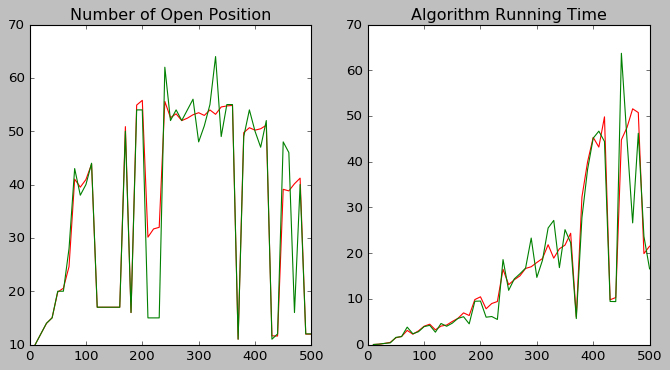

In [0]:
# load optimization data with random weights 
r_w_url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/results/random_optimizations_f.csv'
random_weights = pd.read_csv(r_w_url)
# load optimization data with equal weights
eq_w_url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/results/equal_optimizations_f.csv'
equal_weights = pd.read_csv(eq_w_url)

# create plot figure with certain size
fig = plt.figure(figsize=(10,5))
# create left subplot with average number of open position per loop (portfolio)
plt.subplot(1, 2, 1)
plt.title('Number of Open Position')
plt.plot(random_weights['Num'], random_weights['Mean Num Weights'], color='r')
plt.plot(equal_weights['Num'], equal_weights['Mean Num Weights'], color='g')
# create right subplot with average time of optimization per loop (portfolio)
plt.subplot(1, 2, 2)
plt.title('Algorithm Running Time')
plt.plot(random_weights['Num'], random_weights['Time'], color='r')
plt.plot(equal_weights['Num'], equal_weights['Time'], color='g')


Plotting the graph with number of open positions per portfolio and graph with the time of optimization processes do not give clear representation of what is better to use: random or equal weights. So, let's print averages of this two tables.

In [0]:
print('****Random Weights:****\n'+str(random_weights.mean()))
print('****Equal Weights:****\n'+str(equal_weights.mean()))

****Random Weights:****
Init Weights Param       -0.595715
Mean Opt Param          240.702534
Mean Num Weights         36.077400
Mean Port Return      11490.907000
Mean Optim Iter          48.850400
Num                     255.000000
Time                     16.253962
dtype: float64
****Equal Weights:****
Init Weights Param       -0.590383
Mean Opt Param          247.763424
Mean Num Weights         35.100000
Mean Port Return      11523.020000
Mean Optim Iter          47.920000
Num                     255.000000
Time                     15.775782
dtype: float64


Looking at averages we can find that equal weights give a little benefit compared to random weights. So maybe for purpose of optimizing stock portfolios it is better to use initialization with equal weights.

Now let's go back to the previous plots: we are interested in the number of open positions per portfolio: the lowest and the highest values. Roughly they are 10 and 60 respectively. But if 10 stocks per portfolio is limited by the bounds that we have reset recently, the ceil value is not limited by anything (only by the number of stocks used at the start of optimization).

And here we face the problem of current way of optimization: the large number of stocks at the start can create allocation with a quite large number of stocks (left graph). Sometimes we may have a task to limit this number. Let's try to add new constraint which will “ceil” the maximum number of stocks per portfolio.


In [0]:
def algo_optimization_max_pos(closes_data, weights, st_cap, start, end,
                              max_pos, max_stocks=20, corr_w = 0.001):
        
    def f(opt_w):            
        capital_flow = port_capital_flow(closes_data, st_cap, opt_w)
        fin_indicators = calc_fin_indicators(capital_flow, start, end)        
        return - fin_indicators['sharpe']

    def constraint(x):
        return -1 * (1 - sum(x))
    
    # first count the amount of weights bigger then corr_w, 
    # subtract this value from max_stocks, and then add negative sign    
    def constraint1(x):        
        return -1 * (max_stocks - np.sum((x > corr_w)))
     
    con = ({'type': 'eq', 'fun': constraint},
           {'type': 'eq', 'fun': constraint1})
    
    cur_bounds = [(0.0, max_pos) for l in range(len(weights[0]))]        
    opt_w = weights    
    f(opt_w)
    res = minimize(f, opt_w, method='SLSQP', bounds=cur_bounds, constraints=con,
                   options={'maxiter': 1000, 'ftol': 1e-6})
    
    opt_param_value = -1*res['fun']     
    opt_iter = res['nit']     
    opt_weights = np.round(res['x'], 4)
    
    opt_dict = ({'opt_param_value': opt_param_value,
                 'opt_iter': opt_iter,
                 'opt_weights': opt_weights})

    return opt_dict


In [0]:
eq_opt_dic = optimization_procedure(algo_optimization_max_pos, all_pr_data_closes[:, 0:300], 
                                    pr_start_date, pr_end_date, 100000, 
                                    max_pos=0.1, random=False)
print(eq_opt_dic)

   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0           -0.671387       -0.671387             300.0           99557.0   

   Mean Optim Iter  
0              1.0  


As we can see, added constraint has had no positive effect - no changes to weights have been made (as we've got 300 open position after optimization - the same as number before optimization). This is quite objective because we had implemented the integer constraint (as the number of open positions can be only integer). As follows from the definition of sequential quadratic programming, it is used “on mathematical problems for which the objective function and the constraints are twice continuously differentiable”. And if constraints have to be continuously differentiable, we cannot use SLSQP method to optimizing problems with integer constraints. For this kind of tasks, we have to use integer programming algorithms. But as the integer programming is NP-complete, this could not solve another problem of optimization process: the larger number of stocks we use, the exponential bigger time we (algorithm) will need to find the solution.

So, the goal we have here is "to get the best allocation of particular number of stocks, which gives the best Sharpe ratio, in sensible time". The main thing here is that we want to limit our portfolio by the certain number (n) of stocks. So how can we find the “best n stocks” for our portfolio?

The approach could be the following:


In [0]:
def algo_random_ports(tickers, closes_data, num_of_ports, stocks_in_port,
                      start, end, print_info=True):
    # array to store values of label indicator calculated for each portfolio. 
    # the values have to be added within the indexes of stocks (from "tickers" array) 
    # that were included to portfolio.
    tickers_scores = np.zeros([1, len(tickers)])
    # array to store number of appearances of stocks in all created random portfolios. 
    # +1 added within the indexes of stocks each time when certain stock is added to portfolio 
    tickers_counts = np.ones([1, len(tickers)])
    
    # create loop for every stock
    for i in range(len(tickers)):
        # create list of indexes of all stock tickers 
        cur_range = list(range(len(tickers)))
        # delete from range index of current stock (as it has to be added a priori)
        cur_range.remove(i)
        # start loop for creating p number of ports, where n number of random stocks plus current (i) stock        
        for p in range(num_of_ports):
            # create n number of random indexes within range of number of stocks excluding 
            # the index of "current" stock            
            idx = np.random.choice(cur_range, stocks_in_port - 1, replace=False)
            # add index of "current" stock
            idx = np.append(idx, i)
            
            # slice data to get close prices of stocks from current portfolio     
            data = closes_data[:, idx]            
            # initialize equal weights
            weights = init_weights(data, random=False)            
            # calculate current portfolio performance
            capital_flow = port_capital_flow(data, 10000, weights)
            # calculate desirable indicator
            fin_indicators = calc_fin_indicators(capital_flow, start, end)
            # update score and count arrays
            tickers_scores[0, idx] += fin_indicators['sharpe']
            tickers_counts[0, idx] += 1
    # create DataFrame to check the results            
    rand_df = pd.DataFrame({'symbol': tickers,
                            'sharpe': tickers_scores.tolist()[0],
                            'number': tickers_counts.tolist()[0]})    
    rand_df.to_csv('rand_df.csv', index=False)
    # create stocks rating
    tickers_scores = np.argsort(tickers_scores / tickers_counts)
    best_ind = tickers_scores[0, len(tickers) - stocks_in_port:]    
    best_port = np.asarray(tickers)[best_ind]
    if print_info:      
      print('Average appearance: ' + str(np.mean(tickers_counts)))
      print('StDev of appearance: ' + str(np.std(tickers_counts)))
    
    return best_port, best_ind


The scheme of this approach:

- create n-number of random allocations ("num_of_ports")
- which consist of s-number of stocks ("stocks_in_port")
- calculate Sharpe ratios for each such portfolio
-	derive Sharpe ratio averages for each stock.

The larger average Sharpe ratio the stock has, the more positively it influences on Sharpe ratio of every random portfolio that includes that stock.
Let's run this algorithm.

In [0]:
np.random.seed(1)
# run random algorithm with 10 random portfolios for each stock and 
# 20 stocks in each such portfolio
best_port, best_ind = algo_random_ports(all_pr_tickers, all_pr_data_closes,
                                        10, 20, pr_start_date, pr_end_date)
# print top 20 stocks with the most positive influence on sharpe ratio 
print(best_port)

Average appearance: 201.0
StDev of appearance: 13.839706149600056
['NES' 'FMCIW' 'ARGX' 'BETR' 'TRTC' 'FTFT' 'CBIO' 'MCF' 'NXTD' 'PEER'
 'WSCI' 'SIEB' 'OHRP' 'AMEH' 'TCCO' 'NXTDW' 'CRON' 'AMPE' 'NSPR' 'IMUC']


Now, when we have obtained the portfolio of 20 stocks, we can try to use SLSQP algorithm to optimize their weights.

In [0]:
print('*****Equal*****')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, best_ind],
                                    pr_start_date, pr_end_date, 100000,
                                    max_pos=0.1, random=False, show_w=True)
print(eq_opt_dic)
print('*****Random*****')
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, best_ind],
                                    pr_start_date, pr_end_date, 100000,
                                    max_pos=0.1, random=True, show_w=True)
print(eq_opt_dic)

*****Equal*****
Initialized weights: [[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05]]
Sum of weights: 1.0000000000000002
Performance with init-weights: 306745
Optimized weights: [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
Sum of weights: 1.0
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0       172734.538416   172734.538416              20.0          306745.0   

   Mean Optim Iter  
0              5.0  
*****Random*****
Initialized weights: [[0.04718502 0.06148942 0.05182344 0.0468471  0.03642432 0.05553166
  0.03762218 0.07667145 0.08285227 0.03296693 0.06806968 0.04547249
  0.04883844 0.07957948 0.00610743 0.00749106 0.00173831 0.07158567
  0.06690313 0.07480053]]
Sum of weights: 0.9999999999999998
Performance with init-weights: 324340
Optimized weights: [0.0472 0.0615 0.0518 0.0468 0.0364 0.0555 0.0376 0.0767 0.0829 0.033
 0.0681 0.0455 

As we see any optimization has not been done, although algorithm has done 5 iterations. This could be caused by fact, that any little change in the structure of such stocks allocation has not enough tangible influence on objective function (maximizing Sharpe). But as we see - allocation could be found better than simple equal weights (look at random weights results) - so it makes sense to play around with SLSQP tuning.

In any case, the results of running our random script are very attractive: it found the solution that triples the starting capital (thus the Sharpe ratio is very large) and it has done this almost in 1 minute. The same results you could achieve with the SLSQP method (without constraint of maximum size of portfolio), but this optimization lasts over several hours… If you want you can run it and check the time).


In [0]:
# print('*****Equal*****')
# s_time = time.time()
# # here we set max_pos to 0.05 to set the minimum stocks in portfolio 
# # to 20 (1/0.05=20).
# eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes[:, :-1],
#                                     pr_start_date, pr_end_date, 100000,
#                                     max_pos=0.05, random=False)
# print(eq_opt_dic)
# print(time.time()-s_time)

But there is another thing we should check: it's very likely that our random algorithm has chosen the stocks with very high return relatively to risk. Even if there is a very high risk shown by the stock, very high return could level it and lead to very high Sharpe ratio (100 point of Sharpe ratio sounds very attractive, but “one million” of risk within it - not likely). And to create portfolio with such stocks we don't need complicated algorithms: we can count returns for past period and take the Top-20 (or 10 or 30, etc.) highest yield stocks. Like this:

In [0]:
returns = np.round(list(all_pr_data_closes[-1, :-1]/all_pr_data_closes[0, :-1]), 2)
print('Top-20 highest returns: ' + str(sorted(returns)[len(returns) - 20:]))
sort_returns_idx = np.argsort(returns)
top_20_idx = sort_returns_idx[len(returns) - 20:]
top_20_most_stocks = np.asarray(all_pr_tickers)[top_20_idx]
print('Top-20 highest yield stocks: ' + str(top_20_most_stocks))

Top-20 highest returns: [1.98, 2.0, 2.07, 2.1, 2.19, 2.25, 2.27, 2.33, 2.34, 2.45, 2.47, 2.58, 2.65, 2.67, 2.94, 2.99, 3.29, 4.79, 6.4, 10.67]
Top-20 highest yield stocks: ['DSS' 'JASNW' 'BETR' 'RIOT' 'OHRP' 'PTI' 'LBCC' 'WATT' 'CRON' 'TCCO'
 'AMEH' 'NETE' 'NXTD' 'PEER' 'FTFT' 'AMPE' 'SIEB' 'NXTDW' 'NSPR' 'IMUC']


Someone could say that it would be more correct to calculate the "Sharpest" stocks, but this approach has another problem: the very tiny risk (std) forms the huge Sharpe ratio even if the return is little relatively to another stocks. Probably 5% risk and 50% of return (10 sharp ratio) is much better than 0.5% risk and 5% return (10 sharp ratio). You can check this approach - I've received zero intersection with random algorithm.

So let's compare the list of stocks that were chosen by our random rating algorithm with those that are from simple sorting by return:


In [0]:
overlap_stocks = set(best_port).intersection(top_20_most_stocks) 
print('Overlap Stocks: ' + str(overlap_stocks))
print('Number of Overlap Stocks: ' + str(len(overlap_stocks)))

Overlap Stocks: {'PEER', 'CRON', 'SIEB', 'BETR', 'FTFT', 'NXTD', 'AMEH', 'IMUC', 'AMPE', 'NXTDW', 'OHRP', 'NSPR', 'TCCO'}
Number of Overlap Stocks: 13


We have 13 overlapping stocks from 20, and it is not 100% intersection that is quite reasonable: in random algorithm we calculate the Sharpe ratios not separately for each stock, but in aggregate with other stocks in random allocation. The classical example of positive cross-influence could be the QQQ/TLT 60/40 of their allocation:

In [0]:
# load data
tlt_data = pd.read_csv('https://raw.githubusercontent.com/umachkaalex/random_optimization/master/TLT_2017.csv',
                       converters={'Date': pd.to_datetime})
tlt_data = tlt_data.sort_values(by='Date', ascending=False)
tlt_closes = tlt_data['Adj Close'].values
qqq_data = pd.read_csv('https://raw.githubusercontent.com/umachkaalex/random_optimization/master/QQQ_2017.csv',
                       converters={'Date': pd.to_datetime})
qqq_data = qqq_data.sort_values(by='Date', ascending=False)
qqq_closes = qqq_data['Adj Close'].values
start_year = qqq_data['Date'].iloc[0]
end_year = qqq_data['Date'].iloc[-1]
tlt_weights = np.array([[1]])
# tlt Sharpe ratios
tlt_perf = port_capital_flow(tlt_closes.reshape(len(qqq_data), 1), 10000, tlt_weights)
tlt_fins = calc_fin_indicators(tlt_perf, start_year, end_year)
print('*******TLT Sharpe fins*******')
print(tlt_fins)
# qqq Sharpe ratios
qqq_weights = np.array([[1]])
qqq_perf = port_capital_flow(qqq_closes.reshape(len(qqq_data), 1), 10000, qqq_weights)
qqq_fins = calc_fin_indicators(qqq_perf, start_year, end_year)
print('*******QQQ Sharpe fins*******')
print(qqq_fins)
# tlt/qqq Sharpe ratios
qqq_tlt_weights = np.array([0.6, 0.4])
qqq_tlt_closes = np.concatenate([qqq_closes.reshape(-1,1),tlt_closes.reshape(-1,1)], axis=1)
qqq_tlt_perf = port_capital_flow(qqq_tlt_closes, 10000, qqq_tlt_weights)
qqq_tlt_fins = calc_fin_indicators(qqq_tlt_perf, start_year, end_year)
print('*******QQQ/TLT fins*******')
print(qqq_tlt_fins)

*******TLT Sharpe fins*******
{'sharpe': 0.9475709315616558, 'CAGR': 0.09208961722237441, 'st_dev': 0.09718493271063623}
*******QQQ Sharpe fins*******
{'sharpe': 3.1695429630539564, 'CAGR': 0.327665981250995, 'st_dev': 0.1033795676759902}
*******QQQ/TLT fins*******
{'sharpe': 3.302622592026796, 'CAGR': 0.2222238650553472, 'st_dev': 0.06728709044498178}


Comparing the financial indicators of three performances we can find that after combining QQQ and TLT we get less risk and better Sharpe ratio than QQQ and TLT have separately.

But let's go back to our algorithm. What are the main financial results of random approach and simple rating: return, risk, Sharpe ratio?


In [0]:
# high yield top 20 stocks performance 
top_20_closes = all_pr_data_closes[:, top_20_idx]
top_20_equal_weights = init_weights(top_20_closes, random=False)
top_20_port_perform_equal_weights = port_capital_flow(top_20_closes, 100000, top_20_equal_weights)
top_20_port_return = round(top_20_port_perform_equal_weights[-1]/top_20_port_perform_equal_weights[-0]-1, 2)
top_20_port_equal_weights_params = calc_fin_indicators(top_20_port_perform_equal_weights, pr_start_date, pr_end_date)
print('Top-20 highest yield stocks return: ' + str(top_20_port_return))
print('Top-20 highest yield stocks risk: ' + str(round(top_20_port_equal_weights_params['st_dev'], 2)))

# random rating top 20 stocks performance
random_best_closes = all_pr_data_closes[:, best_ind]
random_best_equal_weights = init_weights(random_best_closes, random=False) 
random_best_perform_equal_weights = port_capital_flow(random_best_closes, 100000, random_best_equal_weights)
random_best_return = round(random_best_perform_equal_weights[-1]/random_best_perform_equal_weights[-0]-1, 2)
random_best_equal_weights_params = calc_fin_indicators(random_best_perform_equal_weights, pr_start_date, pr_end_date)
print('Random Rating best 20 stocks return: ' + str(random_best_return))
print('Random Rating best 20 stocks risk: ' + str(round(random_best_equal_weights_params['st_dev'], 2)))


Top-20 highest yield stocks return: 2.17
Top-20 highest yield stocks risk: 3.03
Random Rating best 20 stocks return: 2.07
Random Rating best 20 stocks risk: 3.12


As we see the results are quite similar but simple sorting seems to be “better” (here we don't compare Sharpe ratios due to short period of time and very high returns).

Actually, both of approaches haven't worked well, because of huge risk that we've got. 200% of return with 300% of risk is not a good idea.

First of all, this happened because we didn't filter our dataset and it includes many "penny" stocks which 50 cent movement causes 50% return and at the same time creates a big risk. And also, we didn't set additional constraint which should have regularized (limited) the maximum of acceptable risk (standard deviation). So, let's implement this constraint to reviewed algorithms and filter our dataset.


In [0]:
print(all_pr_data_closes.shape)
# filter stocks by price (exclude stocks less that 20$ at start of the period)
price_f = (all_pr_data_closes[0, :]>20)
all_pr_tickers = np.asarray(all_pr_tickers)[price_f]
all_pr_data_closes = all_pr_data_closes[:,price_f]
print(all_pr_data_closes.shape)

(21, 5565)
(21, 2717)


In [0]:
def algo_random_ports_risk(tickers, closes_data, num_of_ports, stocks_in_port, 
                           start, end, max_risk, print_info=True):
    
    tickers_scores = np.zeros([1, len(tickers)])     
    tickers_counts = np.ones([1, len(tickers)])
    # array to store values of risk calculated for each portfolio where current stock appeared.
    tickers_risk = np.zeros([1, len(tickers)])
    
    for i in range(len(tickers)):         
        cur_range = list(range(len(tickers)))        
        cur_range.remove(i)                
        for p in range(num_of_ports):            
            idx = np.random.choice(cur_range, stocks_in_port - 1, replace=False)            
            idx = np.append(idx, i)
                 
            data = closes_data[:, idx]           
            weights = init_weights(data, random=False)
            capital_flow = port_capital_flow(data, 10000, weights)            
            fin_indicators = calc_fin_indicators(capital_flow, start, end)
                        
            # update score, risk and count arrays
            tickers_scores[0, idx] += fin_indicators['sharpe']
            tickers_counts[0, idx] += 1            
            tickers_risk[0, idx] += fin_indicators['st_dev']
    
    rand_df_risk = pd.DataFrame({'symbol': tickers,
                                 'sharpe': tickers_scores.tolist()[0],
                                 'number': tickers_counts.tolist()[0],
                                 'st_dev': tickers_risk.tolist()[0]})    
    rand_df_risk.to_csv('rand_df_risk.csv', index=False)
    # count average portfolio risk for each stock appeared at that portfolios  
    tickers_aver_risk = tickers_risk / tickers_counts    
    # create mask to filter stocks that have average risk more than maximum acceptable    
    risk_idx = np.where(tickers_aver_risk < max_risk)
    # filter tickers with risk filter indexes    
    f_tickers = np.asarray(tickers).reshape(1, len(tickers))[:, risk_idx[1]][0]        
    # filter closes data with risk filter indexes
    f_closes_data = closes_data[:, risk_idx[1]]
    # check if number of tickers after filtering by risk is more then required 
    # number of stocks in portfolio
    if len(f_tickers)>stocks_in_port:
      # start random algorithm to define best portfolio allocation using limit_risk stocks
      best_port, best_ind = algo_random_ports(f_tickers, f_closes_data, num_of_ports, 
                                              stocks_in_port, pr_start_date,
                                              pr_end_date, print_info)
      # if the filter by risk return more stocks then required - return True
      return True, best_port, best_ind, f_tickers, f_closes_data
    else:
      # if the filter by risk return less stocks then required - return False
      best_port = ''
      best_ind = ''
      return False, best_port, best_ind, f_tickers, f_closes_data


In [0]:
# np.random.seed(5)
# best_port_risk, best_ind_risk, \
# f_tickers, f_closes_data = algo_random_ports_risk(all_pr_tickers, all_pr_data_closes,
#                                                   10, 20, pr_start_date, pr_end_date, 0.15)
# print(best_port_risk)

In [0]:
# # random 20 stocks performance filtered by risk 
# r_closes = f_closes_data[:, best_ind_risk]
# r_equal_weights = init_weights(r_closes, random=False)
# r_port_perform = port_capital_flow(r_closes, 100000, r_equal_weights)
# r_port_return = round(r_port_perform[-1]/r_port_perform[-0]-1, 4)
# r_port_params = calc_fin_indicators(r_port_perform, pr_start_date, pr_end_date)
# print('Top-20 highest yield stocks return: ' + str(r_port_return))
# print('Top-20 highest yield stocks risk: ' + str(round(r_port_params['st_dev'], 4)))
# print(r_port_params)

33.65% return and 15% risk are good enough indicators of portfolio performance. But are these indicators stable? In other words: why do we use "np.random.seed(5)". Let's pass 10 loops with various seed value:

In [0]:
# for r in range(1,11):
#   np.random.seed(r)
#   print('**************Seed: '+str(r)+'***************')  
#   best_port_risk, best_ind_risk, \
#   f_tickers, f_closes_data = algo_random_ports_risk(all_pr_tickers, all_pr_data_closes,
#                                                     100, 20, pr_start_date, pr_end_date, 0.15,
#                                                     print_info=False)
#   r_closes = f_closes_data[:, best_ind_risk]
#   r_equal_weights = init_weights(r_closes, random=False)
#   r_port_perform = port_capital_flow(r_closes, 100000, r_equal_weights)
#   r_port_return = round(r_port_perform[-1]/r_port_perform[-0]-1, 4)
#   r_port_params = calc_fin_indicators(r_port_perform, pr_start_date, pr_end_date)
#   overlap_stocks = set(best_port_risk).intersection(top_20_most_stocks)  
#   print('Return: ' + str(r_port_return) + ' | Risk: '
#         + str(round(r_port_params['st_dev'], 4)) + ' | Overlap Stocks: '
#         + str(len(overlap_stocks)))
  

The passed loops show that the results of random ports could vary depending on seed value and that risk could be little higher than 0.15 set as limit. Also, there are two "stable things": we don't overlap anymore with high yield stocks and the ratio between return and risk is always more than 1.5. 
But of course, we want to minimize the randomness of final result and get closer to 0.15 risk. We can try to solve this issue by increasing the number of random ports which are created for each ticker. Above you can find such two prints: "Average appearance: 201.0" "StDev of appearance: 13.59" They mean that average appearance of each stock in all random ports is about 200 times with possible divergence +/- 13.6 times.

As we have normal distribution in random algorithm, the number 200 is the result of two parameters: number of ports per 1 stock (10) and number of stocks per 1 portfolio (20). Let's increase "the num_of_ports" and look what we'll get.
For this purpose, I have created a complex loop that will:
1.	Create several loops with different number of random stocks per each loop.
2.	For each such stock sampling we will run several loops with different numbers of random ports that have to be created during running random algorithm.
3.	Compare results for between all these samplings. 

This looping takes quite a lot of time, so we can jump directly to results.


In [0]:
# # the list of numbers of stocks to choose randomly for using in algorythm
# number_of_stocks = [100, 200, 400, 700, 1100]

# # start loop for each number of random stocks
# for cur_num_st in number_of_stocks:
#   print('**************Number of stocks: ' + str(cur_num_st) + '***************')
#   url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/pr_data_closes.csv'
#   # load previous month data
#   all_pr_data_closes = pd.read_csv(url)
#   # delete columns (stocks) with zero closes
#   all_pr_data_closes = all_pr_data_closes.replace(0, pd.np.nan).dropna(axis=1)
#   # create list of symbols 'Date' column
#   all_pr_tickers = all_pr_data_closes.columns.tolist()[:-1]

#   # convert dataframes to numpy arrays without 'Date' column
#   all_pr_data_closes = all_pr_data_closes.values[:,:-1]

#   # set start/end dates for previous and next periods  
#   pr_start_date = pd.to_datetime('11/30/2017')
#   pr_end_date = pd.to_datetime('12/31/2017')
  
#   # random choose the number of id, defined by the loop, 
#   cur_range = np.random.choice(np.arange(all_pr_data_closes.shape[1]), cur_num_st, replace=False)
  
#   # keep the closes and tickers from dataset according to random id
#   all_pr_data_closes = all_pr_data_closes[:, cur_range]
#   all_pr_tickers = [all_pr_tickers[i] for i in range(len(all_pr_tickers)) if i in cur_range]  
  
#   # define the number of random ports which we will create per loop,
#   # the number of random stocks per port is fixed: 20
#   random_ports = [10, 20, 40, 70, 110, 160, 220, 290, 370, 460, 560, 670]
  
#   # lists to store results for each loop of current number of stocks ('cur_num_st')
#   all_returns = []
#   all_risks = []
#   all_tickers = []
  
#   # start loops
#   for ports in random_ports:      
#       # lists to store results of cur loop various random seeds
#       returns = []
#       risk = []
#       best_tickers = []
      
#       # start loops with various random seeds to run random algorithm
#       for r in range(1, 31):            
#         np.random.seed(r)    
#         best_port_risk, best_ind_risk, \
#         f_tickers, f_closes_data = algo_random_ports_risk(all_pr_tickers, all_pr_data_closes,
#                                                           ports, 20, pr_start_date, pr_end_date,
#                                                           0.15, print_info=False)
#         r_closes = f_closes_data[:, best_ind_risk]
#         r_equal_weights = init_weights(r_closes, random=False)
#         r_port_perform = port_capital_flow(r_closes, 100000, r_equal_weights)
#         r_port_return = round(r_port_perform[-1]/r_port_perform[-0]-1, 4)
#         r_port_params = calc_fin_indicators(r_port_perform, pr_start_date, pr_end_date)
#         overlap_stocks = set(best_port_risk).intersection(top_20_most_stocks)        
#         for ticker in best_port_risk:
#           if ticker not in best_tickers:
#             # save tickers that appeared in all random port during current random seed loop
#             best_tickers.append(ticker)
#         # save tickers that appeared in all random port during current random seed loop
#         returns.append(r_port_return)
#         risk.append(round(r_port_params['st_dev'], 4))
      
#       # save results of current number of random ports loop 
#       all_returns.append(returns)
#       all_risks.append(risk)
#       all_tickers.append(best_tickers)    
  
#   # print results of all number of random ports loops
#   # for current number of random stocks loop
 
#   print(all_returns)
#   print(all_risks)
#   print(all_tickers)

We will load the results of this loops from dictionary saved as json file.

In [0]:
# import urllib and json libraries
import urllib.request, json

# read txt file from web and convert to json
url = 'https://raw.githubusercontent.com/umachkaalex/stockmarket/random_optimization/results/results_random_looping.json'
with urllib.request.urlopen(url) as response:
   html = response.read()
results_random_looping = json.loads(html)

# print dictionary keys 
result_keys = results_random_looping.keys()
print(result_keys)
print(type(results_random_looping['100']))
print(len(results_random_looping['100']))
print(results_random_looping['100'])

dict_keys(['100', '200', '400', '700', '1100', '2170'])
<class 'list'>
4
[[10, 20, 40, 70, 110, 160, 220, 290, 370, 460, 560, 670], [[0.0964, 0.0989, 0.0981, 0.0969, 0.0975, 0.0989, 0.1006, 0.0976, 0.0978, 0.0981, 0.0973, 0.0978, 0.1011, 0.101, 0.0869, 0.0961, 0.0985, 0.0925, 0.0975, 0.0966, 0.0975, 0.0996, 0.0944, 0.0983, 0.098, 0.1003, 0.0934, 0.0934, 0.0936, 0.0961], [0.1003, 0.101, 0.0992, 0.1003, 0.1011, 0.0974, 0.1024, 0.1002, 0.0974, 0.1002, 0.1009, 0.1006, 0.1009, 0.0981, 0.1004, 0.0977, 0.1022, 0.0999, 0.0975, 0.1004, 0.1022, 0.1022, 0.1004, 0.0992, 0.1008, 0.1012, 0.1002, 0.1006, 0.0995, 0.0978], [0.1011, 0.1007, 0.1011, 0.1004, 0.1008, 0.1022, 0.1011, 0.1004, 0.1024, 0.1006, 0.1022, 0.1013, 0.1011, 0.1011, 0.1022, 0.1004, 0.1012, 0.1022, 0.1023, 0.1012, 0.1022, 0.1005, 0.1022, 0.1022, 0.1022, 0.0982, 0.1009, 0.1004, 0.1009, 0.1012], [0.1009, 0.1024, 0.1022, 0.1022, 0.1022, 0.1023, 0.1022, 0.1022, 0.1022, 0.1019, 0.1022, 0.1024, 0.1022, 0.1022, 0.1022, 0.1023, 0.1024, 0.1022,

We've got 6 lists: for 100, 200 ... 2170 random stocks.

Each of them contains 4 lists:
1.	'number of random ports',
2.	'returns for 1.2...30 different random seeds',
3.	'risks for 1.2...30 different random seeds',
4.	'tickers that appeared in random ports for 1.2...30 different random seeds'.

Let's plot graphs to visualize results for 100 - 1100 random stocks.


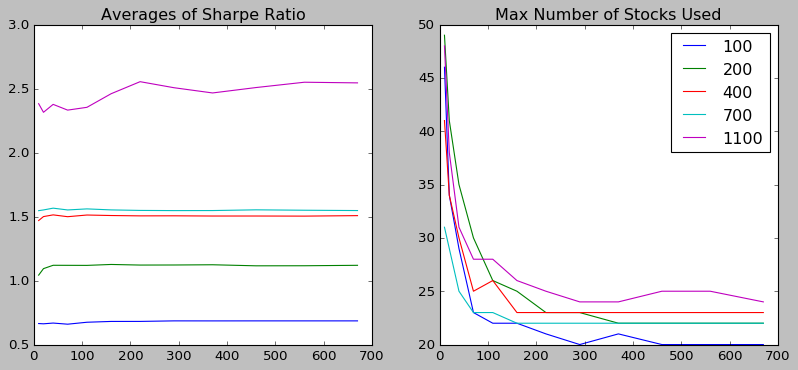

In [0]:
# combine results in groups by type
sharps = []
tickers = []
num_rand_ports = []
for key in list(result_keys)[:-1]:
  num_rand_ports.append(results_random_looping[key][0])
  cur_ret = results_random_looping[key][1]  
  cur_risk = results_random_looping[key][2]    
  cur_sharp = np.asarray(cur_ret)/np.asarray(cur_risk)    
  cur_sharp = [np.mean(sharps) for sharps in cur_sharp]
  sharps.append(cur_sharp)
  cur_tickers = results_random_looping[key][3]
  cur_tickers = [len(tick) for tick in cur_tickers]
  tickers.append(cur_tickers)

num_rand_ports = np.asarray(num_rand_ports).T
sharps = np.asarray(sharps).T
tickers = np.asarray(tickers).T

# define the list of number of random ports.
# because for '100-1100' loops it is the same, so we take it from the 1st one. 
# create plot figure with certain size
fig = plt.figure(figsize=(12,5))
# create left subplot with averages of sharpe ratios per current number of random ports
plt.subplot(1, 2, 1)
plt.title('Averages of Sharpe Ratio')
plt.plot(num_rand_ports, sharps)
# create right subplot with maximum number of stocks that appeared in all random ports
plt.subplot(1, 2, 2)
plt.title('Max Number of Stocks Used')
plt.plot(num_rand_ports, tickers)
label = list(result_keys)[:-1]
plt.legend(label, loc='best')

In [0]:
# sharps = [[sharp_list[i]/sharp_list[0] for i in range(len(sharp_list))] for sharp_list in sharps]
# tickers = [[ticker_list[i]/ticker_list[0] for i in range(len(ticker_list))] for ticker_list in sharps]

As we can notice the increase of random ports number that we create during random algorithm leads to decrease of differences in results made by various random seeds. For example, for 400 random stocks (red line) increasing the number of random ports up to 160 (x-axis) has positive effect but for more than 160 random ports it has no improving effect, so any random seed that we would use, gives us about the same result if we created more than 160 portfolios while running algorithm.

On the other side, this number (160 or 100 or 200 or etc) varies depending on the amount of stocks that we use during sessions (100, 200, 400, 700 or 1100). And to be sure that continuation of executing script has no sense (in other words: any increase of the number of random ports doesn't significantly decrease the difference in results) we can use Elbow method to stop. Below there are calculations by this method in relation to graphs above.


In [0]:
def elbow_method(data, early_stop_k=1):
  
  # list to store 'elbow' values of each step
  elbow_signals = []
  
  # initialize early stop variable
  early_stop = 0
  
  # start calculation for each step starting from the second
  for i in range(1, len(data)-1):        
    # prevent division by zero 
    if data[i-1] != data[i]:
      # calculate current step elbow signal
      cur_signal = (data[i] - data[i+1])/(data[i-1] - data[i])      
      if i != 1:
        # check if current step signal lower then previous
        if cur_signal <= elbow_signals[-1]:
          # if lower - add to list
          elbow_signals.append(cur_signal)
        else:
          # if not lower - check if early stop value doesn't equal base value
          if early_stop != early_stop_k:
            # if not - add 1 to early stop and store signal to list
            early_stop += 1            
            elbow_signals.append(cur_signal)
          else:
            # if equal - stop calculation
            break
      else:
        # if i equal 1 - simpy store signal because nothing to compare
        elbow_signals.append(cur_signal)
    else:   
      # if data[i-1] == data[i] (denominator is zero)
      # check if early stop value doesn't equal base value            
      if early_stop != early_stop_k:
        # if not add one to it
        early_stop += 1        
      else:
        # if equal - stop calculation
        break
  # return the number of step at which we stop
  return i

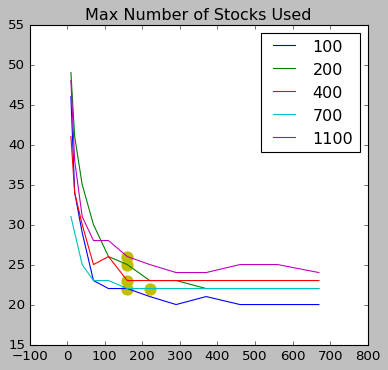

In [0]:
tickers_stop_steps_x = []
tickers_stop_steps_y = []

for i in range(len(list(result_keys)[:-1])) :  
  key = list(result_keys)[:-1][i]
  cur_tickers = results_random_looping[key][3]
  cur_tickers = [len(tick) for tick in cur_tickers]         
  stop_point = elbow_method(cur_tickers)  
  tickers_stop_steps_x.append(np.asarray(num_rand_ports)[:, i][stop_point])
  tickers_stop_steps_y.append(np.asarray(tickers)[:, i][stop_point])
  

# create plot figure with certain size
fig = plt.figure(figsize=(12,5))
# create right subplot with maximum number of stocks that appeared in all random ports
plt.subplot(1, 2, 2)
plt.title('Max Number of Stocks Used')
plt.plot(num_rand_ports, tickers)
label = list(result_keys)[:-1]
plt.legend(label, loc='best')
plt.scatter(tickers_stop_steps_x, tickers_stop_steps_y, color='y', s=100)



As we see the elbow method could be very useful to stop random algorithm when the further running seems to be not efficient. The implementation of the preventing from early stops mechanism allows to tune this process more accurately (you can play with changing the 'early_stop_k' to 0 or 2 to see different results).

In 'results_random_looping' dictionary there is one more key: 2170. Let's plot it and use elbow function to see how it works now.


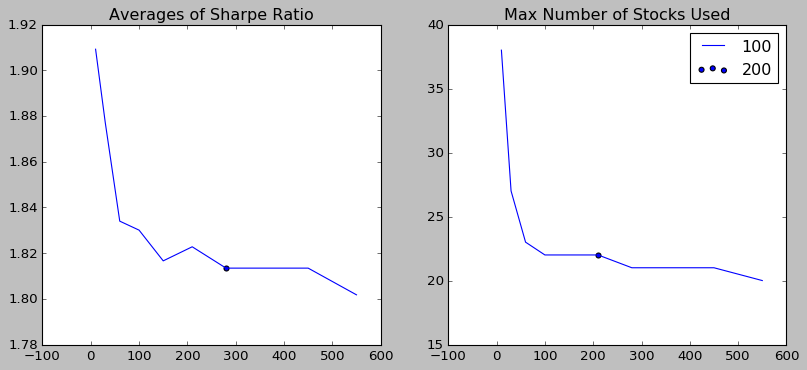

In [0]:
num_rand_ports = results_random_looping['2170'][0]  
cur_ret = results_random_looping['2170'][1]  
cur_risk = results_random_looping['2170'][2]    
# calculate sharpe ratio
cur_sharp = np.asarray(cur_ret)/np.asarray(cur_risk)    
cur_sharp = [np.mean(sharps) for sharps in cur_sharp]
# elbow stop for average sharpe ratio
elbow_sharp = elbow_method(cur_sharp)
elbow_sharp_x = num_rand_ports[elbow_sharp]
elbow_sharp_y = cur_sharp[elbow_sharp]
# count tickers
cur_tickers = results_random_looping['2170'][3]
cur_tickers = [len(tick) for tick in cur_tickers]
# elbow stop for max tickers
elbow_tickers = elbow_method(cur_tickers)
elbow_tickers_x = num_rand_ports[elbow_tickers]
elbow_tickers_y = cur_tickers[elbow_tickers]

# create plot figure with certain size
fig = plt.figure(figsize=(12,5))
# create left subplot with averages of sharpe ratios per current number of random ports
plt.subplot(1, 2, 1)
plt.title('Averages of Sharpe Ratio')
plt.plot(num_rand_ports, cur_sharp)
plt.scatter(elbow_sharp_x, elbow_sharp_y)
# create right subplot with maximum number of stocks that appeared in all random ports
plt.subplot(1, 2, 2)
plt.title('Max Number of Stocks Used')
plt.plot(num_rand_ports, cur_tickers)
plt.scatter(elbow_tickers_x, elbow_tickers_y)
label = list(result_keys)[:-1]
plt.legend(label, loc='best')

And in this case we would stop the execution of script when there is no big difference in results of increasing the number of random portfolios.

It's time to add elbow method to random algorithm.


In [0]:
# def random_algorithm_fixed_num_of_ports(num_rndm_ports):
#   start_time = time.time()        
#   success, best_port_risk, best_ind_risk, \
#   f_tickers, f_closes_data = algo_random_ports_risk(all_pr_tickers, all_pr_data_closes,
#                                                     num_rndm_ports, 20, 
#                                                     pr_start_date, pr_end_date,
#                                                     0.15, print_info=False)
#   # if random algorithm passed two stages (filtering by risk and sharp maximization)
#   if success:
#     # then calculate results for best stocks
#     r_closes = f_closes_data[:, best_ind_risk]          
#     r_equal_weights = init_weights(r_closes, random=False)
#     r_port_perform = port_capital_flow(r_closes, 100000, r_equal_weights)
#     r_port_return = round(r_port_perform[-1]/r_port_perform[-0]-1, 4)
#     r_port_params = calc_fin_indicators(r_port_perform, pr_start_date, pr_end_date)              
#     print('Execution time with '+str(num_rndm_ports) + ' random ports: ' \
#         + str(round(time.time()-start_time, 2)))
#     return r_port_params
  
    
#   else:
#     # in another case print error
#     print('after risk filter there are less than required stocks')
#     print('Execution time with '+str(num_rndm_ports) + ' random ports: ' \
#         + str(round(time.time()-start_time, 2)))
#     return {'sharpe': 0, 'CAGR': 0, 'st_dev': 0}
    
# url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/pr_data_closes.csv'
# all_pr_data_closes_b = pd.read_csv(url)
# all_pr_data_closes_b = all_pr_data_closes_b.replace(0, pd.np.nan).dropna(axis=1)
# all_pr_tickers_b = all_pr_data_closes_b.columns.tolist()[:-1]
# all_pr_data_closes_b = all_pr_data_closes_b.values[:,:-1]
# # create random id to choose 500 stocks to use
# np.random.seed(4)
# rand_idx = np.random.choice(np.arange(all_pr_data_closes_b.shape[1]), 500, replace=False)
# # slice the stock prices according to random ids of stocks in dataset
# all_pr_data_closes = all_pr_data_closes_b[:, rand_idx]  
# # create list of tickers of stocks
# all_pr_tickers = [all_pr_tickers_b[i] for i in range(len(all_pr_tickers_b)) if i in rand_idx] 
# # list of numbers of random portfolios to use in algorithm
# random_ports = [10, 20, 40, 70, 110, 160, 220, 290, 370, 460, 560, 670]
# # store results
# rnd_port_10_results = []
# rnd_port_100_results = []
# elbow_stop_results = []

# # start loop to create 5 different random algorithm runs
# for l in range(10):  
#   print('**********Loop: ' + str(l) + '**********')
  
#   # create lists to store values
#   all_tickers = []
#   len_tickers = []  
#   elbow_signals = []
#   np.random.seed(np.random.randint(0, 1000, size=1))  
  
#   # start random algorithm for 10 random ports without elbow stopping
#   rnd_port_10_results.append(random_algorithm_fixed_num_of_ports(10)) 
  
#   # start random algorithm for 100 random ports without elbow stopping
#   rnd_port_100_results.append(random_algorithm_fixed_num_of_ports(100))
  
#   # start random algorithm with increase of number of  random ports with elbow stopping
#   start_time = time.time() 
  
#   for ports in random_ports:
#       success, best_port_risk, best_ind_risk, \
#       f_tickers, f_closes_data = algo_random_ports_risk(all_pr_tickers, all_pr_data_closes,
#                                                         ports, 20, pr_start_date, pr_end_date,
#                                                         0.15, print_info=False)
#       if success:
#         all_tickers.extend(best_port_risk)
#         all_tickers = list(set(all_tickers))      
#         len_tickers.append(len(all_tickers))      
#         if len(len_tickers) > 2:
#           elbow_signals.append(elbow_method(len_tickers))        
#           if len(elbow_signals) > 1 and elbow_signals[-1] == elbow_signals[-2]:          
#             r_closes = f_closes_data[:, best_ind_risk]          
#             r_equal_weights = init_weights(r_closes, random=False)
#             r_port_perform = port_capital_flow(r_closes, 100000, r_equal_weights)
#             r_port_return = round(r_port_perform[-1]/r_port_perform[-0]-1, 4)
#             r_port_params = calc_fin_indicators(r_port_perform, pr_start_date, pr_end_date)      
#             elbow_stop_results.append(r_port_params)            
#             print('Execution time with elbow stop ('+ str(ports) + 'random ports): '\
#                   + str(round(time.time()-start_time, 2)))
#             break
#       else:
#         print('there are less than required stocks after risk filtering')
#         break

# print(rnd_port_10_results)
# print(rnd_port_100_results)
# print(elbow_stop_results)

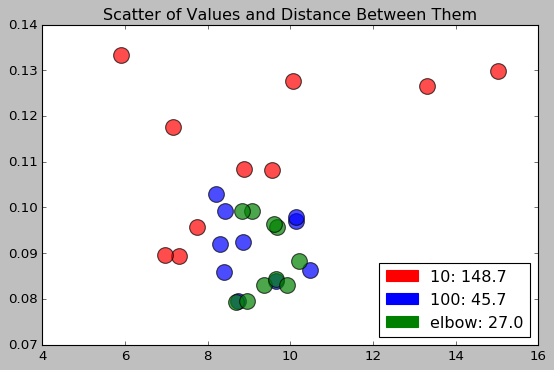

In [0]:
import matplotlib.patches as mpatches

# load dictionary with results of above script
url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/results/dict_3_results.json'
with urllib.request.urlopen(url) as response:
   html = response.read()
results_3_looping = json.loads(html)

# function to calculate distances between points
def calc_plot_dstn(cntr):  
  # create numpy array to store points
  points = np.zeros([len(cntr), 2])
  # list to store distances between points
  distances = []  
  for i in range(len(cntr)):
    dctn = cntr[i]
    # as x we take 'CAGR', as y - 'StDev'
    point = np.array([dctn['CAGR'], dctn['st_dev']])    
    if i > 0:
      # calculate distances between current point and all previous points      
      dist = np.sqrt(np.sum(np.square(points[:i,:] - point), axis=1))
      # save distances to list
      distances.extend(list(dist))
    # add current to array of all points
    points[i, :] = point  
  # return the sum of distances of all points of current dictionary
  return sum(distances)

colors = ['r', 'b', 'g']
keys = list(results_3_looping.keys())
distances = []

# create plot figure with certain size
fig = plt.figure(figsize=(8,5))

for i in range(len(keys)):  
  cur_dict = results_3_looping[keys[i]]
  distances.append(calc_plot_dstn(cur_dict))
  for dctn in cur_dict:
    plt.scatter(dctn['CAGR'], dctn['st_dev'], c=colors[i], s=200, alpha=0.7)


patches = [mpatches.Patch(color=colors[i], label=str(str(keys[i]) + ': ' \
           + str(round(distances[i], 1))))  for i in range(len(keys)) ]

plt.title('Scatter of Values and Distance Between Them')
plt.legend(handles=patches, loc=4, numpoints=1)


From the previous plots we can conclude the following:

1.	The increase in number of random portfolios (which we initialize to proceed filtering by risk and calculate 20 stocks with the best Sharpe ratio) leads to decrease in differences of results which we obtain during different random seed values. Thus, there is no need to worry about running algorithm with certain random seed.
2.	Elbow stopping allows to break the algorithm when the further execution will not give a noticeable improvement in results (of maximization the Sharpe ratio).
3.	'Averages of Sharpe Ratio' plot (the first one) also shows the relationship between the number of stocks we input to algorithm to find the best 20 and the value of Sharpe ratio: the more stocks we use - the bigger Sharpe ratio the algorithm can find (the better combination of 20 stocks).

One more important topic that we have not yet discussed is the time of running algorithm. Execution with elbow stopping and 500 stocks (the last slicing) in average lasts 5-6 minutes. Let's compare it with the execution time of SLSQP optimization with the same stocks selection.


In [0]:
url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/pr_data_closes.csv'
all_pr_data_closes_b = pd.read_csv(url)
all_pr_data_closes_b = all_pr_data_closes_b.replace(0, pd.np.nan).dropna(axis=1)
all_pr_tickers_b = all_pr_data_closes_b.columns.tolist()[:-1]
all_pr_data_closes_b = all_pr_data_closes_b.values[:,:-1]
np.random.seed(4)
rand_idx = np.random.choice(np.arange(all_pr_data_closes_b.shape[1]), 500, replace=False)
all_pr_data_closes = all_pr_data_closes_b[:, rand_idx]  
all_pr_tickers = [all_pr_tickers_b[i] for i in range(len(all_pr_tickers_b)) if i in rand_idx]

print(all_pr_data_closes.shape)
print('*****Equal*****')
s_time = time.time()
# here we set max_pos to 0.05 to set the minimum stocks in portfolio 
# to 20 (1/0.05=20).
eq_opt_dic = optimization_procedure(algo_optimization, all_pr_data_closes,
                                    pr_start_date, pr_end_date, 100000,
                                    max_pos=0.05, random=False, show_f=True)
print(eq_opt_dic)
print(time.time()-s_time)

(21, 500)
*****Equal*****
{'sharpe': 246.6701631051451, 'CAGR': 118.81769203018477, 'st_dev': 0.4816865182820583}
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            2.158133      246.324954              21.0          150152.0   

   Mean Optim Iter  
0             11.0  
12.848036527633667


The optimal result has been received in about 13 sec. But despite such huge advantage in time, the SLSQP algorithm "proposes" the portfolio with allocation of 21 stocks (that is close to our goal), but almost 0.5 point of risk, that is very far from 0.1 that random algorithm (with risk filter set to 0.15) gave us.

As we found out, we cannot implement the integer constraint within SLSQP algorithm, but float constraint that has to limit risk can be appropriate. Let's do it.


In [0]:
def algo_optimization_risk(closes_data, weights, st_cap, start, end, max_pos,
                           risk=0.15):
    # objective function    
    def f(opt_w):        
        capital_flow = port_capital_flow(closes_data, st_cap, opt_w)                
        fin_indicators = calc_fin_indicators(capital_flow, start, end)        
        return - fin_indicators['sharpe']

    # constrains
    def constraint(x):        
        return -1 * (1 - sum(x))
    
    # add risk constrain
    def constraint_risk(x):
      capital_flow = port_capital_flow(closes_data, st_cap, x)                
      fin_indicators = calc_fin_indicators(capital_flow, start, end)              
      return -1 * (fin_indicators['st_dev'] - risk)
    
    # add constrains to dictionary 
    con = ({'type': 'eq', 'fun': constraint},
           {'type': 'eq', 'fun': constraint_risk})
        
    cur_bounds = [(0.0, max_pos) for l in range(len(weights[0]))]
    
    # execute SLSQP optimization process
    opt_w = weights   
    f(opt_w)
    res = minimize(f, opt_w, method='SLSQP', bounds=cur_bounds, constraints=con,
                   options={'maxiter': 1000, 'ftol': 1e-10})
    
    # extract some values from dictionary with results
    opt_param_value = -1*res['fun']    
    opt_iter = res['nit']    
    opt_weights = np.round(res['x'], 4)
    
    # put this variables into dictionary:
    opt_dict = ({'opt_param_value': opt_param_value,
                 'opt_iter': opt_iter,
                 'opt_weights': opt_weights})

    return opt_dict


In [0]:
print(all_pr_data_closes.shape)
print('*****Equal*****')
s_time = time.time()
# here we set max_pos to 0.05 to set the minimum stocks in portfolio 
# to 20 (1/0.05=20).
eq_opt_dic = optimization_procedure(algo_optimization_risk, all_pr_data_closes,
                                    pr_start_date, pr_end_date, 100000,
                                    max_pos=0.05, random=False, show_f=True)
print(eq_opt_dic)
print(time.time()-s_time)

(21, 500)
*****Equal*****
{'sharpe': 293.6658835493218, 'CAGR': 43.963161785844115, 'st_dev': 0.14970469587578228}
   Init Weights Param  Mean Opt Param  Mean Num Weights  Mean Port Return  \
0            2.158133      292.434572              24.0          138159.0   

   Mean Optim Iter  
0             27.0  
44.040379762649536


Now we have received acceptable risk and even better Sharpe ratio than random algorithm. Time has tripled, but still superiorly. But we see the increase in amount of stocks after optimization - now it is 24.

To check how execution time of two approaches changes depending on amount of stocks, let's run such code (or jump to results, because it lasts long).


In [0]:
# # define the list of numbers of stocks used in optimization
# num_of_stocks = [50, 100, 250, 500, 1000, 2000, 3300, 5000]
# # the list of number of random ports to use in random algorithm
# random_ports = [10, 20, 40, 70, 110, 160, 220, 290, 370, 460, 560, 670]

# # run loops with different number of stocks used in optimization
# for num in num_of_stocks:    
#   print('\n*****Number of stocks: ' + str(num) + '*****')
#   url = 'https://raw.githubusercontent.com/umachkaalex/random_optimization/master/pr_data_closes.csv'
#   all_pr_data_closes_b = pd.read_csv(url)
#   all_pr_data_closes_b = all_pr_data_closes_b.replace(0, pd.np.nan).dropna(axis=1)
#   all_pr_tickers_b = all_pr_data_closes_b.columns.tolist()[:-1]
#   all_pr_data_closes_b = all_pr_data_closes_b.values[:,:-1]
  
#   # if random choice of stocks chooses mainly high risk stocks, random algorihtm
#   # will produce the error. So if there is error after risk filtering, algorithm
#   # will run from start creating new random slice of stocks till we wouldn't pass
#   # filtering with success.
#   success = False
#   while not success:
#     # create random id to choose current number of stocks to use
#     np.random.seed(np.random.randint(0, 1000, size=1))  
#     rand_idx = np.random.choice(np.arange(all_pr_data_closes_b.shape[1]), num, replace=False)

#     all_pr_data_closes = all_pr_data_closes_b[:, rand_idx]    
#     all_pr_tickers = [all_pr_tickers_b[i] for i in range(len(all_pr_tickers_b)) if i in rand_idx] 
    
#     # start random algorithm
#     print('\n    *****Random algorithm*****')

#     all_tickers = []
#     len_tickers = []  
#     elbow_signals = []  

#     start_time = time.time() 
#     for ports in random_ports:
#         success, best_port_risk, best_ind_risk, \
#         f_tickers, f_closes_data = algo_random_ports_risk(all_pr_tickers, all_pr_data_closes,
#                                                           ports, 20, pr_start_date, pr_end_date,
#                                                           0.15, print_info=False)
#         if success:
#           all_tickers.extend(best_port_risk)
#           all_tickers = list(set(all_tickers))      
#           len_tickers.append(len(all_tickers))      
#           if len(len_tickers) > 2:
#             elbow_signals.append(elbow_method(len_tickers))        
#             if len(elbow_signals) > 1 and elbow_signals[-1] == elbow_signals[-2]:          
#               r_closes = f_closes_data[:, best_ind_risk]          
#               r_equal_weights = init_weights(r_closes, random=False)
#               r_port_perform = port_capital_flow(r_closes, 100000, r_equal_weights)
#               r_port_return = round(r_port_perform[-1]/r_port_perform[-0]-1, 4)
#               r_port_params = calc_fin_indicators(r_port_perform, pr_start_date, pr_end_date)                    
#               print(r_port_params)
#               print('    Execution time with elbow stop ('+ str(ports) + 'random ports): '\
#                     + str(round(time.time()-start_time, 2)))
#               break
#         else:
#           print('    there are less than required stocks after risk filtering')
#           break  
  
#   # start SLSQP algorithm
#   print('\n    *****SLSQP with risk constrain*****')  
#   start_time = time.time()
#   eq_opt_dic = optimization_procedure(algo_optimization_risk, all_pr_data_closes,
#                                       pr_start_date, pr_end_date, 100000,
#                                       max_pos=0.05, random=False, show_f=True)

#   print(eq_opt_dic.iloc[:,1:3])  
#   print('    Execution time SLSQP: ' + str(round(time.time()-start_time, 2)))

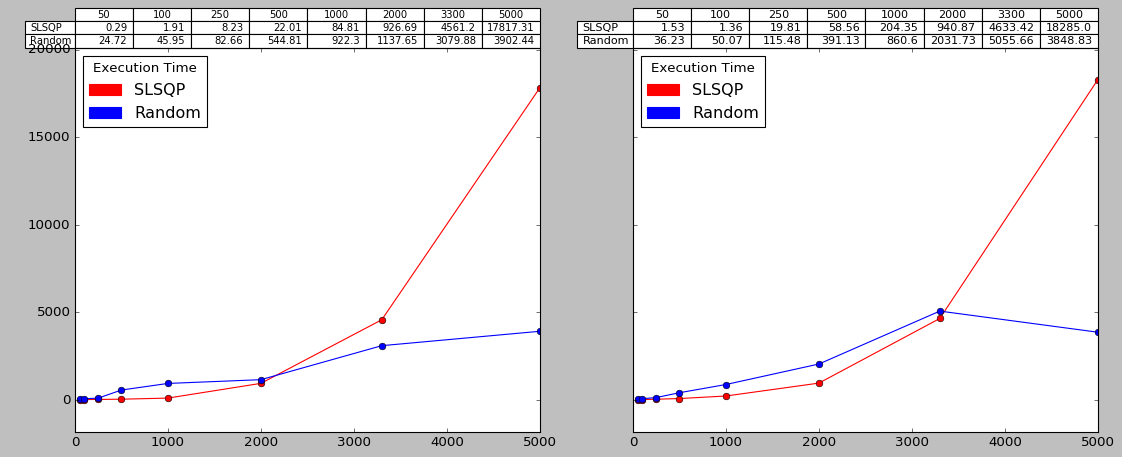

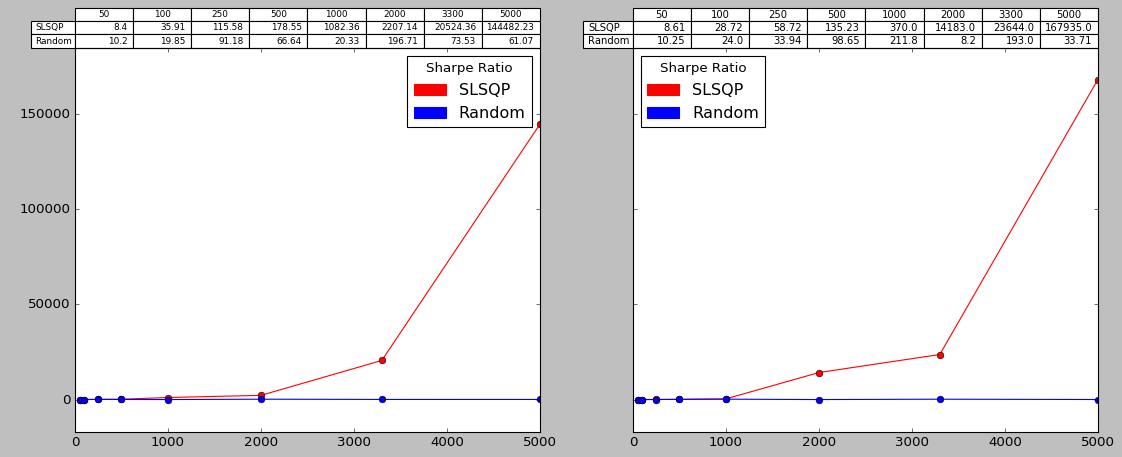

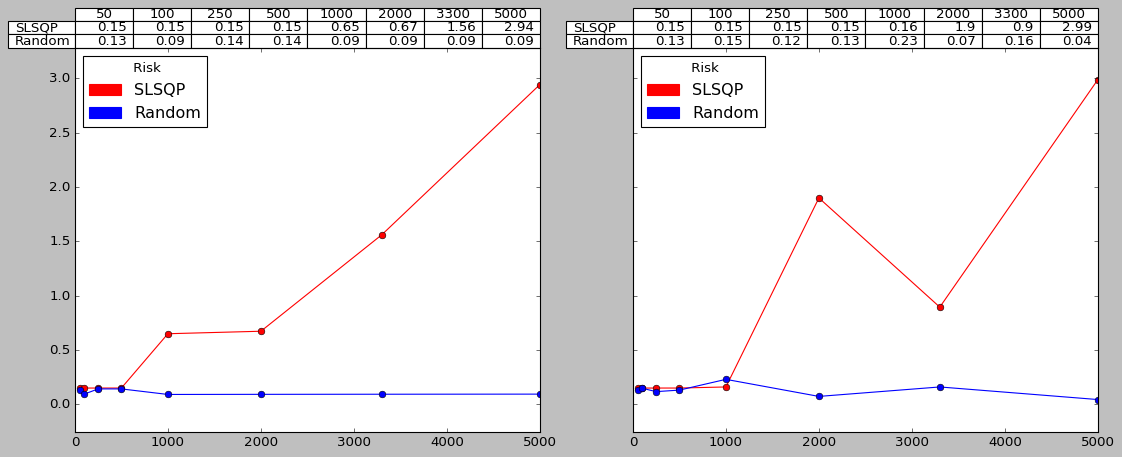

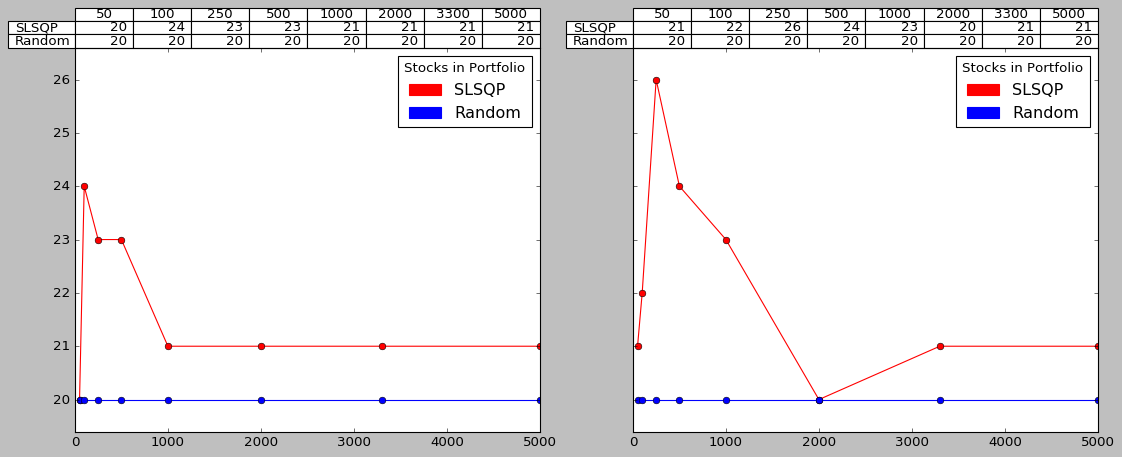

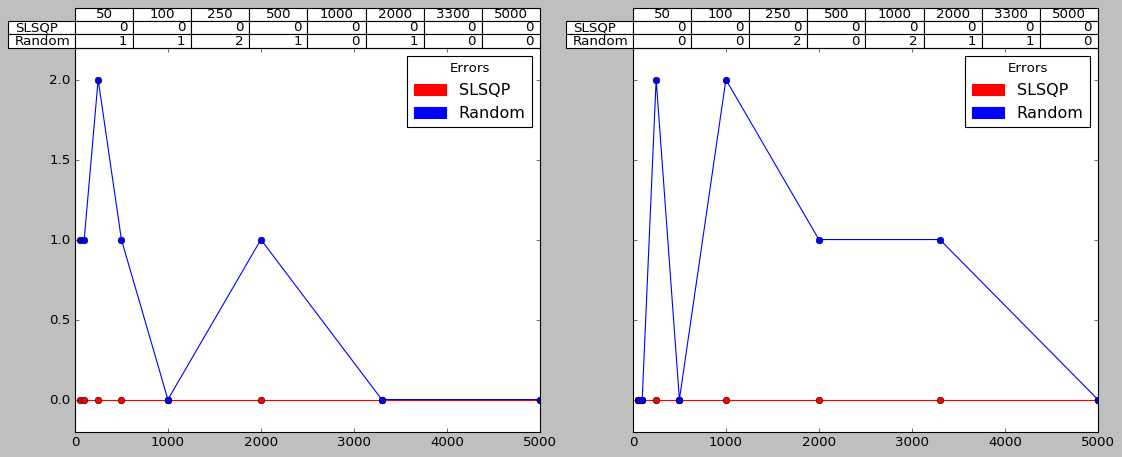

In [0]:
# load results of above loops
results_1 = pd.read_csv('https://raw.githubusercontent.com/umachkaalex/random_optimization/master/results/time_compare_SLSQP_Random.csv')
results_2 = pd.read_csv('https://raw.githubusercontent.com/umachkaalex/random_optimization/master/results/time_compare_SLSQP_Random1.csv')
# define x-axis number of stocks
num_stocks = results_1['Num_Stocks'].tolist()
# extract columns to generate graphs
columns = results_1.columns.tolist()[1:]
# some variables to create graphs
keys = ['SLSQP', 'Random']
colors = ['r', 'b']
titles = ['Execution Time', 'Sharpe Ratio', ' Risk', 'Stocks in Portfolio', 'Errors']

# start creating graphs for 2 runnings of above script
for i in range(int(len(columns)/2)):  
  # create figure
  f, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize=[16.5,6])
  # plot lines: SLSQP and random lines from two different files but for the same topic ('title')
  ax.plot(num_stocks, results_1[columns[i*2]], c='r', marker='o')  
  ax2.plot(num_stocks, results_2[columns[i*2]], c='r', marker='o')
  ax.plot(num_stocks, results_1[columns[i*2+1]], c='b', marker='o')  
  ax2.plot(num_stocks, results_2[columns[i*2+1]], c='b', marker='o')  
  
  # plot legend
  patches = [mpatches.Patch(color=colors[i], label=str(str(keys[i]))) for i in range(len(keys))]  
  ax.legend(handles=patches, loc='best', title=titles[i])
  ax2.legend(handles=patches, loc='best', title=titles[i])
  
  # plot table with results of current topic ('title')
  the_table = ax.table(cellText=[results_1[columns[i*2]].round(2),
                                  results_1[columns[i*2+1]].round(2)],
                        rowLabels=keys,                        
                        colLabels=num_stocks,
                        loc='top')
  
  the_table2 = ax2.table(cellText=[results_2[columns[i*2]].round(2),
                                  results_2[columns[i*2+1]].round(2)],
                         rowLabels=keys,                        
                         colLabels=num_stocks,
                         loc='top')
  # increase y-axis to make graphs look more watchable
  y_min = np.min([results_1[columns[i*2]],                         
                  results_1[columns[i*2+1]]])
  y_max = np.max([results_1[columns[i*2]],
                  results_1[columns[i*2+1]]])
  ax.set_ylim([y_min-(y_max - y_min)*0.1,
                 y_max+(y_max - y_min)*0.1])  
  
  y_min = np.min([results_2[columns[i*2]],
                  results_2[columns[i*2+1]]])  
  y_max = np.max([results_2[columns[i*2]],
                  results_2[columns[i*2+1]]])
  ax2.set_ylim([y_min-(y_max - y_min)*0.1,
                 y_max+(y_max - y_min)*0.1])

Analyzing these graphs, first of all, it is striking that with increase of number of input features (stocks in our case), the time of finding optimal solution by SLSQP method rises like in geometric progression.

Secondly, after 1000 input stocks, SLSQP method can't handle risk constrains: the risk of optimized allocation starts to rise. It rises in line with Sharpe ratio which indicates that SLSQP first of all 'tries' to optimize objective function.

Looking at random algorithm results, we can notice linear increase of execution time and stable holding of risk limit. But as for objective: maximizing the Sharpe ratio, we see that it loses to SLSQP optimization. This is because of fulfilling risk filtering at first and after that Sharpe maximization. Also, such approach leads to rare errors in random algorithm (when there are less stocks then required after risk filtering).

Brief conclusions.

SLSQP disadvantages:
- Its running time increases in geometric progression with the increase of input features.
-	It cannot handle constraints after n-number of input features.
- It doesn't support integer constraints.

SLSQP advantages:
- It finds optimal solution almost instantly for a small amount if input features.
- It maximizes the objective function better.

Random approach disadvantages:
- It's not able to maximize objective function all time as SLSQP can.

Random approach advantages:
- Increase in running time has linear dependence on amount of input features.
- It always does not allow to break the constraints.

So, if you have not a "big" amount of input features to optimize (for example you want to minimize delivery costs of 500 goods that you're selling) it's better to use SLSQP alike methods. But if there are more than 1000 goods and you need to take certain constraints into account, it's better to code something like this proposed random algorithm. Maybe, if we combine two methods in one: for example, the first runs random risk filtering and then maximizes Sharpe ratio with SLSQP - it will give us acceptable execution time, handling the risk limits and stable increase in Sharpe ratio (with the increase of number of input features, stocks in this case).

Also, the time execution of random method can be reduced by implementing it with Numba library, which runs calculations on GPU.
